<a href="https://colab.research.google.com/github/KunalTUM/KunalTUM/blob/main/NHP_HF_lesion_segmentation_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **U-Net for NHP Lesion Segmentation**

# Setup

In [ ]:
# !pip install patchify
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import random
# from patchify import patchify, unpatchify

# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data from drive
# NHP1 - training
# NHP2 - testing
nhp1 = np.load('/content/drive/MyDrive/Colab Notebooks/NHP_lesion_segmentation_DL/NHP_08078.npy', allow_pickle=True)
nhp2 = np.load('/content/drive/MyDrive/Colab Notebooks/NHP_lesion_segmentation_DL/NHP_08112.npy', allow_pickle=True)
nhp3 = np.load('/content/drive/MyDrive/Colab Notebooks/NHP_lesion_segmentation_DL/NHP_08671.npy', allow_pickle=True)
# fd = np.load('NHP_08112.npy', allow_pickle = True)

# print(type(nhp1)) # it shows ndarray but this is a dictionary
# x_train = nhp1.item().get('x_train')
# print(len(x_train))

In [ ]:
## Functions for data augmentation

# Function for making patches and labelling them as 0 or 1 for DL training - class balanced
def data_augmentation(slice, slice_mask, number_of_patches, size_of_patches):

    x_train_0 = np.zeros((size_of_patches, size_of_patches, int(number_of_patches/2)))
    y_train_0 = np.zeros((size_of_patches, size_of_patches, int(number_of_patches/2)))
    y_label_0 = int(number_of_patches/2)

    x_train_1 = np.zeros((size_of_patches, size_of_patches, int(number_of_patches/2)))
    y_train_1 = np.zeros((size_of_patches, size_of_patches, int(number_of_patches/2)))
    y_label_1 = int(number_of_patches/2)

    l = slice_mask.shape[0]
    m = slice_mask.shape[1]

    p_l = size_of_patches
    p_m = size_of_patches

    i = 0
    j = 0

    if size_of_patches > slice_mask.shape[0]:
        print('\nPatch size is larger than image size. Please enter smaller size.')
    elif (number_of_patches % 2) != 0:
        print('\nNumber of patches is an odd number. Please enter Even number!')
    else:

        while y_label_1 > 0:
            c_x = random.randint(0, l - p_l - 1)
            c_y = random.randint(0, m - p_m - 1)

            x_patch_1 = slice[int(c_x):int(c_x + p_l), int(c_y):int(c_y + p_m)]
            y_patch_1 = slice_mask[int(c_x):int(c_x + p_l), int(c_y):int(c_y + p_m)]

            if (np.sum(y_patch_1) > 0):
                y_label_1 = y_label_1 - 1
                x_train_1[:, :, i] = x_patch_1
                y_train_1[:, :, i] = y_patch_1
                i = i + 1

        y_label_1_array = np.ones(int(number_of_patches/2))

        while y_label_0 > 0:
            c_x = random.randint(0, l - p_l - 1)
            c_y = random.randint(0, m - p_m - 1)

            x_patch_0 = slice[int(c_x):int(c_x + p_l), int(c_y):int(c_y + p_m)]
            y_patch_0 = slice_mask[int(c_x):int(c_x + p_l), int(c_y):int(c_y + p_m)]

            if (np.sum(y_patch_0) == 0):
                y_label_0 = y_label_0 - 1
                x_train_0[:, :, j] = x_patch_0
                y_train_0[:, :, j] = y_patch_0
                j = j + 1

        y_label_0_array = np.zeros(int(number_of_patches/2))

        x_train_0 = np.concatenate([x_train_0, x_train_1], axis=2)
        y_train_0 = np.concatenate([y_train_0, y_train_1], axis=2)
        y_label_0_array = np.concatenate([y_label_0_array, y_label_1_array])

        x_train = x_train_0
        y_train = y_train_0
        y_label = y_label_0_array

        x_train = x_train.astype('int')
        y_train = y_train.astype('int')
        y_label = y_label.astype('int')

        x_train = np.swapaxes(x_train, 0, 2)        # swaping axes because shuffle needs all axis=0 to be same. y_label has different axis=0 as compared to x_train and y_train
        y_train = np.swapaxes(y_train, 0, 2)
        x_train, y_train, y_label = shuffle(x_train, y_train, y_label, random_state=0)

    return x_train, y_train, y_label


# Function for converting NHP input dictionary into array with patches
def convert_input2array(data, number_of_patches, size_of_patches):
    # extract x_train and y_train keys from dictionary
    x_train = data.item().get('x_train')
    y_train = data.item().get('y_train')

    # Create patches from first slice to initialize further concatenation
    slice_x_init = x_train[0]
    slice_y_init = y_train[0]
    slice_x_init_patch, slice_y_init_patch, slice_y_init_label = data_augmentation(slice_x_init, slice_y_init, number_of_patches, size_of_patches)
    print('First slice patchified')

    # create patches from remaining slices and combine them all together
    for i in range(len(x_train)-1):
        slice_x = x_train[i+1]
        slice_y = y_train[i+1]
        slice_x_patch, slice_y_patch, slice_y_label = data_augmentation(slice_x, slice_y, number_of_patches, size_of_patches)
        print('Slice being patchified: ', i+1)
        slice_x_init_patch = np.concatenate([slice_x_init_patch, slice_x_patch], axis=0)
        slice_y_init_patch = np.concatenate([slice_y_init_patch, slice_y_patch], axis=0)

    x_train_final = slice_x_init_patch
    y_train_final = slice_y_init_patch

    return x_train_final, y_train_final


In [ ]:
patch_number = 2500
patch_size = 64

# Convert NHP training data into arrays with patches
x_train_1, y_train_1 = convert_input2array(nhp1, patch_number, patch_size)   # argument order - NHP input, number of patches, size of patches

#Increase dynamic range of the input by multiplying with 4096 (DICOM std max.)
x_train_1 = 4096 * x_train_1

print('x train: ', x_train_1.shape)
print('y train: ', y_train_1.shape)



# Convert NHP training data into arrays with patches
x_train_2, y_train_2 = convert_input2array(nhp2, patch_number, patch_size)   # argument order - NHP input, number of patches, size of patches

#Increase dynamic range of the input by multiplying with 4096 (DICOM std max.)
x_train_2 = 4096 * x_train_2

print('x train: ', x_train_2.shape)
print('y train: ', y_train_2.shape)



# Concatenate two NHPs
x_train_1 = np.concatenate((x_train_1, x_train_2), axis=0)
y_train_1 = np.concatenate((y_train_1, y_train_2), axis=0)

x_train_final = x_train_1
y_train_final = y_train_1
print('x train final: ', x_train_final.shape)
print('y train final: ', y_train_final.shape)


# Convert NHP testing data into arrays with patches
x_test_final, y_test_final = convert_input2array(nhp3, patch_number, patch_size)

#Increase dynamic range of the input by multiplying with 4096 (DICOM std max.)
x_test_final = 4096 * x_test_final

print('x test: ', x_test_final.shape)
print('y test: ', y_test_final.shape)

First slice patchified
Slice being patchified:  1
Slice being patchified:  2
Slice being patchified:  3
x train:  (10000, 64, 64)
y train:  (10000, 64, 64)
First slice patchified
Slice being patchified:  1
x train:  (5000, 64, 64)
y train:  (5000, 64, 64)
x train final:  (15000, 64, 64)
y train final:  (15000, 64, 64)
First slice patchified
Slice being patchified:  1
Slice being patchified:  2
Slice being patchified:  3
Slice being patchified:  4
Slice being patchified:  5
Slice being patchified:  6
Slice being patchified:  7
Slice being patchified:  8
Slice being patchified:  9
Slice being patchified:  10
x test:  (27500, 64, 64)
y test:  (27500, 64, 64)


In [ ]:
# If testing on NHP3, then it should be y_test
# Otherwise, y_train

# By mistake there are three labels - 0,1,2 in NHP3. Changing the label 2 to label 1 for NHP3
# before training the model, change the label. Otherwise it will cause problem.
# identify which variable has NHP3 data and then assign that variable here.
y_test_final[y_test_final == 2] = 1
print(np.max(y_test_final))

1


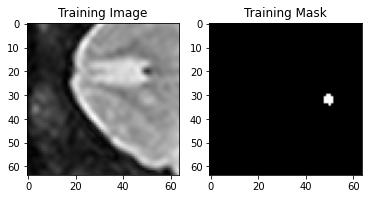

In [ ]:
# Plot random sample from training data
import random

image_number = random.randint(0, x_train_final.shape[0])

fig = plt.figure()
plt.subplot(1, 2, 1)
plt.title('Training Image')
plt.imshow(x_train_final[image_number,:,:], cmap="gray")
plt.subplot(1, 2, 2)
plt.title('Training Mask')
plt.imshow(y_train_final[image_number,:,:], cmap="gray")
plt.show()


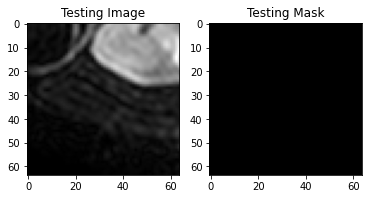

In [ ]:
# Plot random sample from testing data
import random

image_number = random.randint(0, x_test_final.shape[0])

fig = plt.figure()
plt.subplot(1, 2, 1)
plt.title('Testing Image')
plt.imshow(x_test_final[image_number,:,:], cmap="gray")
plt.subplot(1, 2, 2)
plt.title('Testing Mask')
plt.imshow(y_test_final[image_number,:,:], cmap="gray")
plt.show()


# U-Net Building blocks

In [ ]:
# # Building Unet by dividing encoder and decoder into blocks

# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
# from keras.optimizers import Adam
# from keras.layers import Activation, MaxPool2D, Concatenate


# def conv_block(input, num_filters):
#     x = Conv2D(num_filters, 3, padding="same")(input)
#     x = BatchNormalization()(x)   #Not in the original network.
#     x = Activation("relu")(x)

#     x = Conv2D(num_filters, 3, padding="same")(x)
#     x = BatchNormalization()(x)  #Not in the original network
#     x = Activation("relu")(x)

#     return x

# #Encoder block: Conv block followed by maxpooling


# def encoder_block(input, num_filters):
#     x = conv_block(input, num_filters)
#     p = MaxPool2D((2, 2))(x)
#     return x, p

# #Decoder block
# #skip features gets input from encoder for concatenation

# def decoder_block(input, skip_features, num_filters):
#     x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
#     x = Concatenate()([x, skip_features])
#     x = conv_block(x, num_filters)
#     return x

# #Build Unet using the blocks
# def build_unet(input_shape, n_classes):
#     inputs = Input(input_shape)

#     s1, p1 = encoder_block(inputs, 64)
#     s2, p2 = encoder_block(p1, 128)
#     s3, p3 = encoder_block(p2, 256)
#     s4, p4 = encoder_block(p3, 512)

#     b1 = conv_block(p4, 1024) #Bridge

#     d1 = decoder_block(b1, s4, 512)
#     d2 = decoder_block(d1, s3, 256)
#     d3 = decoder_block(d2, s2, 128)
#     d4 = decoder_block(d3, s1, 64)

#     if n_classes == 1:  #Binary
#       activation = 'sigmoid'
#     else:
#       activation = 'softmax'

#     outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
#     print(activation)

#     model = Model(inputs, outputs, name="U-Net")
#     return model

# Build the U-Net Model

In [ ]:
# IMG_HEIGHT = x_train_final.shape[1]
# IMG_WIDTH  = x_train_final.shape[2]
# IMG_CHANNELS = 1  # because its grey scale

# input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
# print(input_shape)

In [ ]:
# model = build_unet(input_shape, n_classes=1)
# model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

# Compile and Train U-Net

In [ ]:
# history = model.fit(x_train_final, y_train_final,
#                     batch_size = 16,
#                     verbose=1,
#                     epochs=25,
#                     validation_data=(x_test_final, y_test_final),
#                     shuffle=False)

In [ ]:
# #Save the model for future use
# model.save('/content/drive/MyDrive/Colab Notebooks/NHP_lesion_segmentation_DL/saved_models/NHP_lesion_segmentation_Train_2_3_Test_1.hdf5')

# Learning curve from model history

In [ ]:
# #plot the training and validation accuracy and loss at each epoch
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# images_dir = '/content/drive/MyDrive/Colab Notebooks/NHP_lesion_segmentation_DL/loss_curves'
# plt.savefig(f"{images_dir}/Training_and_validation_loss - Train_2_3_Test_1.png")
# plt.show()



# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# plt.plot(epochs, acc, 'y', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# images_dir = '/content/drive/MyDrive/Colab Notebooks/NHP_lesion_segmentation_DL/accuracy_curves'
# plt.savefig(f"{images_dir}/Training_and_validation_accuracy - Train_2_3_Test_1.png")
# plt.show()


# Predictions with U-Net model

In [ ]:
#Load previously saved model
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Colab Notebooks/NHP_lesion_segmentation_DL/saved_models/NHP_lesion_segmentation_Train_1_2_Test_3.hdf5", compile=False)

In [ ]:
#IOU
y_pred = model.predict(x_test_final)
y_pred_thresholded = y_pred > 0.5

860/860 [==============================] - 46s 41ms/step


In [ ]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes = n_classes)
IOU_keras.update_state(y_pred_thresholded, y_test_final)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.5859697


(1, 64, 64)
1/1 [==============================] - 1s 733ms/step
(64, 64)


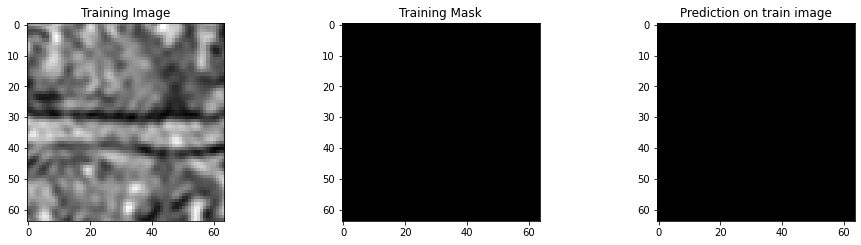

In [ ]:
# Predictions on Training data

threshold = 0.5
test_img_number = random.randint(0, len(x_train_final)-1)
test_img        = x_train_final[test_img_number]
ground_truth    = y_train_final[test_img_number]

test_img_input = np.expand_dims(test_img, 0)    # adding an extra dimension to the vector
print(test_img_input.shape)                     # doing it because model.predict requires extra dimension

prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Training Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Training Mask')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(233)
plt.title('Prediction on train image')
plt.imshow(prediction, cmap='gray')

plt.show()

test_img.shape:  (64, 64)
(1, 64, 64)
1/1 [==============================] - 0s 21ms/step
(64, 64)


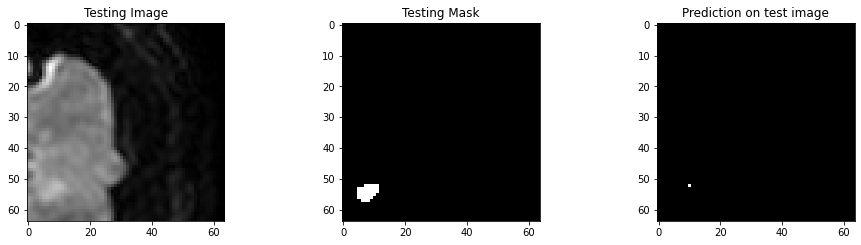

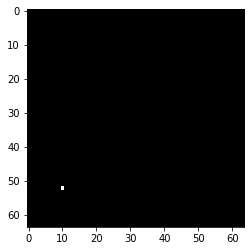

In [ ]:
# Predictions on Testing data

threshold = 0.5
# test_img_number = random.randint(0, len(x_test_final)-1)
test_img_number = random.randint(25000, 27499)
test_img        = x_test_final[test_img_number]
ground_truth    = y_test_final[test_img_number]
print('test_img.shape: ', test_img.shape)

test_img_input = np.expand_dims(test_img, 0)    # adding an extra dimension to the vector
print(test_img_input.shape)                     # doing it because model.predict requires extra dimension

prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Mask')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


# multiplication with original image
tissue = test_img * prediction
fig = plt.figure()
plt.imshow(tissue, cmap="gray")
plt.show()


# Saving the prediction
np.save("/content/drive/MyDrive/Colab Notebooks/NHP_lesion_segmentation_DL/Predictions/High_Field/NHP3/x_TP11.npy", test_img)
np.save("/content/drive/MyDrive/Colab Notebooks/NHP_lesion_segmentation_DL/Predictions/High_Field/NHP3/y_TP11.npy", prediction)
np.save("/content/drive/MyDrive/Colab Notebooks/NHP_lesion_segmentation_DL/Predictions/High_Field/NHP3/y_tissue_TP11.npy", tissue)

In [ ]:
# ## Predictions on individual NHP - not working - because testing on a completely new data.

# nhp_number = nhp1
# slice_number = 1

# patch_number = 2500
# patch_size = 64

# x_test = nhp_number.item().get('x_train')
# y_test = nhp_number.item().get('y_train')

# x_test_slice = x_test[slice_number]
# y_test_slice = y_test[slice_number]

# x_test_final, y_test_final, y_test_labels = data_augmentation(x_test_slice, y_test_slice, patch_number, patch_size)


# # making predicition
# threshold = 0.5
# test_img_number = random.randint(0, len(x_test_final)-1)
# test_img        = x_test_final[test_img_number]
# ground_truth    = y_test_final[test_img_number]
# print('test_img.shape: ', test_img.shape)

# test_img_input = np.expand_dims(test_img, 0)    # adding an extra dimension to the vector
# print(test_img_input.shape)                     # doing it because model.predict requires extra dimension

# prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
# print(prediction.shape)

# plt.figure(figsize=(16, 8))
# plt.subplot(231)
# plt.title('Testing Image')
# plt.imshow(test_img, cmap='gray')
# plt.subplot(232)
# plt.title('Testing Mask')
# plt.imshow(ground_truth, cmap='gray')
# plt.subplot(233)
# plt.title('Prediction on test image')
# plt.imshow(prediction, cmap='gray')

# plt.show()


# # multiplication with original image
# tissue = test_img * prediction
# fig = plt.figure()
# plt.imshow(tissue, cmap="gray")
# plt.show()


# # saving prediction
# np.save("/content/drive/MyDrive/Colab Notebooks/NHP_lesion_segmentation_DL/Predictions/High_Field/NHP1/x_test_pred_TP2.npy", test_img)
# np.save("/content/drive/MyDrive/Colab Notebooks/NHP_lesion_segmentation_DL/Predictions/High_Field/NHP1/y_test_pred_TP2.npy", prediction)
# np.save("/content/drive/MyDrive/Colab Notebooks/NHP_lesion_segmentation_DL/Predictions/High_Field/NHP1/y_test_pred_tissue_TP2.npy", tissue)

In [ ]:
# # Predictions on complete image

# # Extract slice from NHP
# test_nhp      = nhp1
# slice_number  = 3

# x_test_all_slices = test_nhp.item().get('x_train')
# y_test_all_slices = test_nhp.item().get('y_train')
# test_img          = x_test_all_slices[slice_number]
# ground_truth      = y_test_all_slices[slice_number]

# # Patchify input
# IMG_HEIGHT                = x_train_final.shape[1]
# IMG_WIDTH                 = x_train_final.shape[2]
# step                      = IMG_WIDTH  # same as image width because we don't want overlapping
# patch_height, patch_width = IMG_HEIGHT, IMG_WIDTH
# patch_shape               = (patch_height, patch_width)
# patches                   = patchify(test_img, patch_shape, step=step)
# print(patches.shape)

# # Predict model on each patch
# output_patches = np.empty(patches.shape).astype(np.uint8)
# for i in range(patches.shape[0]):
#     for j in range(patches.shape[1]):
#         patch = patches[i, j, :, :]
#         test_img_input = np.expand_dims(patch, 0)
#         prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
#         # Viewing single slice
#         fig = plt.figure()
#         plt.imshow(prediction, cmap="gray")
#         plt.show()
#         output_patches[i, j] = prediction

# # Unpatchify output
# output_height     = test_img.shape[0] -(test_img.shape[0] - patch_height) % step
# output_width      = test_img.shape[1] -(test_img.shape[1] - patch_width) % step
# output_shape      = (output_height, output_width)
# output_prediction = unpatchify(output_patches, output_shape)

# # Plotting
# plt.figure(figsize=(16, 8))
# plt.subplot(231)
# plt.title('Testing Image')
# plt.imshow(test_img, cmap='gray')
# plt.subplot(232)
# plt.title('Testing Mask - Ground Truth')
# plt.imshow(ground_truth, cmap='gray')
# plt.subplot(233)
# plt.title('Prediction on test image')
# plt.imshow(output_prediction, cmap='gray')

# plt.show()